# Portfolio Currator

## Part 1. Importing Libraries and Dependencies

In [2]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [3]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

## Part 2. Importing Data
Part one of the project is largely made up of pulling in the data, cleaing the data, and visualizing it for use later in the portfolio currator.
The primary goal of the Data creation segment of the project will be to have a dataframe with the expected percent change in medical costs, in relation to age.


In [4]:
# Import the data by reading in the CSV file 
# Review the first 5 rows of the DataFrame
medical_costs_df = pd.read_csv(
    Path("../Resources/Medical_Cost.csv"),
)
medical_costs_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


1. Review of MD Data :


,charges
age,
18,7086.217556
19,9747.909335
20,10159.697736
21,4730.464330
22,10012.932802


2. Visualizations of MD Data :


<AxesSubplot:title={'center':'Line plot visualization of medical insurance charges data'}, xlabel='age'>

<AxesSubplot:title={'center':'Bar plot visualization of medical insurance charges data'}, xlabel='age'>

<AxesSubplot:title={'center':'Bar plot visualization of pct_change in medical insurance charges, based on age'}, xlabel='age'>

<AxesSubplot:title={'center':'Histogram plot visualizing the of standard deviation in medical insurance charges pct_change() data, based on age'}, ylabel='Frequency'>

3. Summary Statistics of MD Data :


,charges
count,47.000000
mean,13720.545008
std,4322.618833
min,4730.464330
25%,10313.569650
50%,12719.110358
75%,16305.865369
max,23275.530837


age
18         NaN
19    0.375615
20    0.042244
21   -0.534389
22    1.116691
Name: charges, dtype: float64

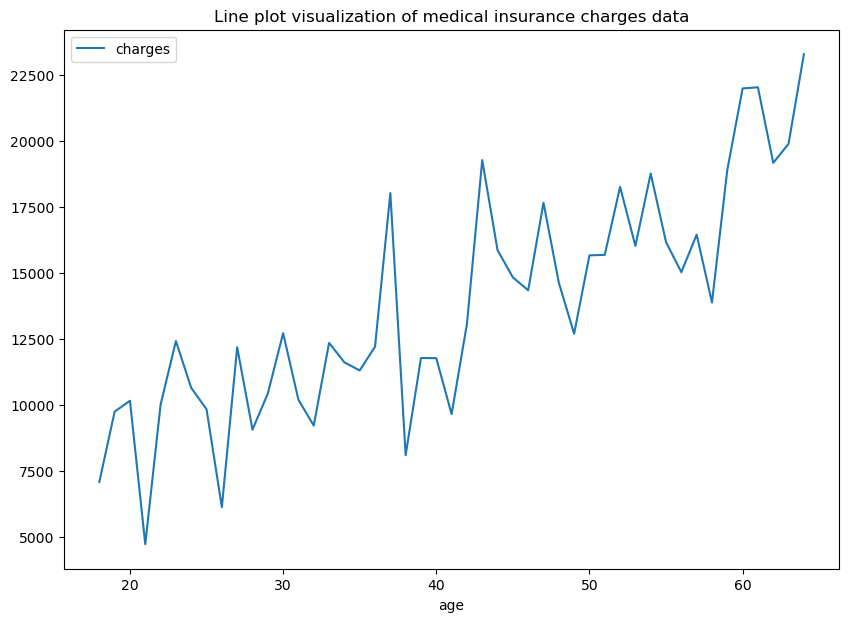

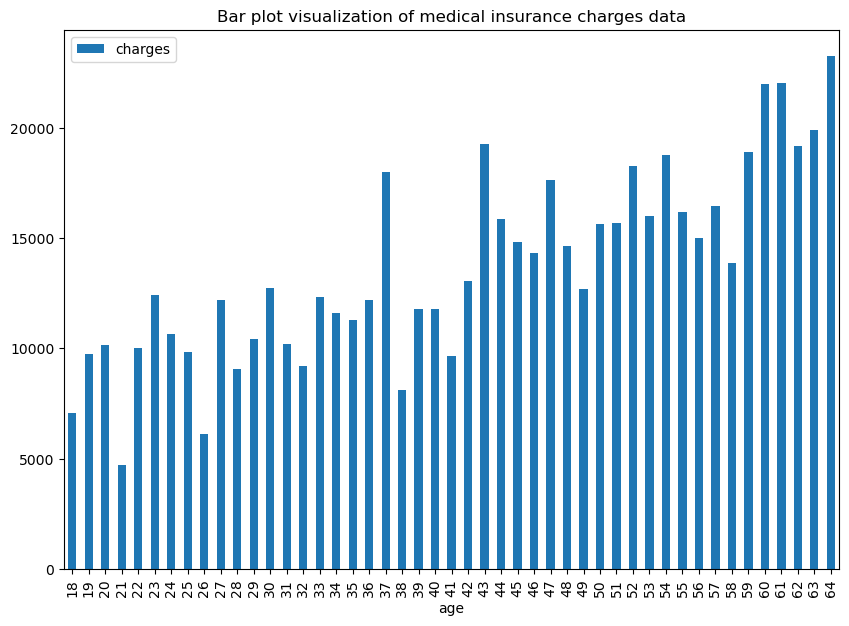

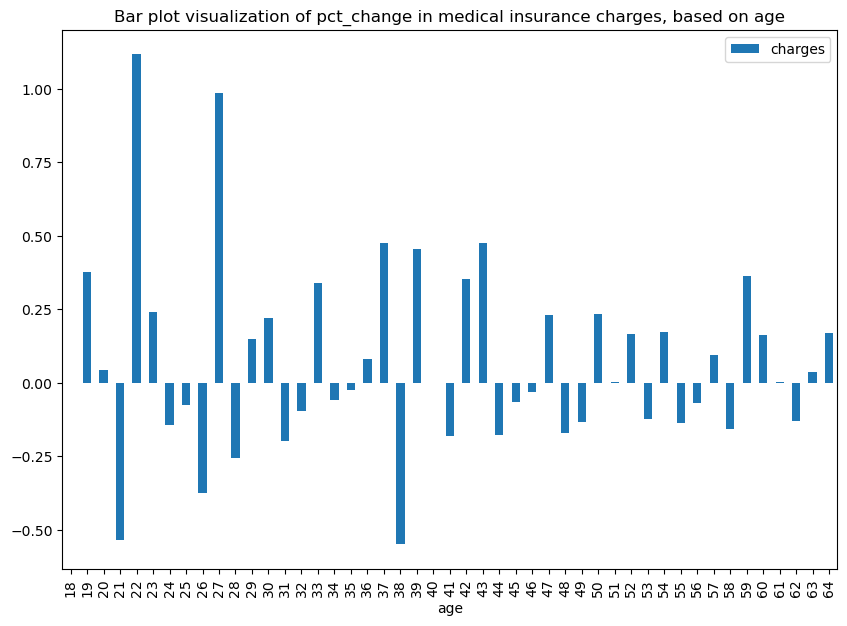

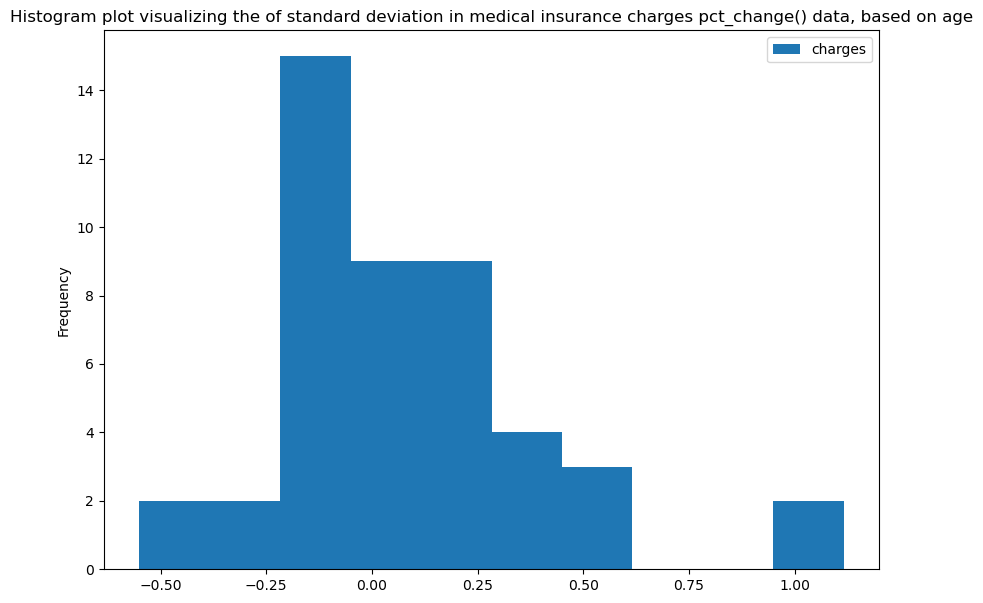

In [62]:
# Creating a Dataframe holding grouped based on charges, and age.

md_cost_age_df = (
 medical_costs_df[["charges", "age"]]
 .groupby("age")
 .mean()
 .sort_values("age")
)
# Reviewing dataframe
print("1. Review of MD Data :")
display(md_cost_age_df.head())

# Visualizing the Dataframe, with different plots. Using .pct_change() to get the percentage
# Change in data values.
print("2. Visualizations of MD Data :")
display(md_cost_age_df.plot(
    kind='line', 
    y= "charges",
    figsize=(10,7),
    title = "Line plot visualization of medical insurance charges data"
))

display(md_cost_age_df.plot(
    kind='bar', 
    y= "charges",
    figsize=(10,7),
    title = "Bar plot visualization of medical insurance charges data"
    
))

display(md_cost_age_df.pct_change().plot(
    kind='bar', 
    y= "charges",
    figsize=(10,7),
    title = "Bar plot visualization of pct_change in medical insurance charges, based on age"
    
))
display(md_cost_age_df.pct_change().plot(
    kind='hist', 
    y= "charges",
    figsize=(10,7),
    title = "Histogram plot visualizing the of standard deviation in medical insurance charges pct_change() data, based on age"
    
))

# Creating summary statistics of the data.
print("3. Summary Statistics of MD Data :")
display(md_cost_age_df.describe())

md_cost_age_df_change = md_cost_age_df['charges'].pct_change()
display(md_cost_age_df_change.head())

### DATA COLLECTION : Cleaning and Reviewing the Data.
The acquired data needs some working with, as there is a high standard deviation in the pct_change() data of the dataset, and the correlation is not strong enough between increases in MD insurance costs. To solve this issue, I will find the average year-to-year increase from the entire dataset, instead of first focusing on age, and see if this changes the data outcome! 

In [90]:
md_cost_age_df = (
 medical_costs_df[["charges", "age"]]
 .groupby("age")
 .median()
 .pct_change()
 .sort_values("age")
)
display(md_cost_age_df.mean())
print(f" Based on the data, an average annual pct_change() in total medical insurance costs, between the ages of 18 and 64 should end up at a roughly +7.0581% annually")

print("Based on these results, the user should definetely look to invest sooner, so as not to miss out on the time-value of money!")

print(

SyntaxError: unexpected EOF while parsing (608592061.py, line 13)

### WRAP UP :

Though the data isn't 'perfect', the application with all its simulations can only help the user 'predict; how thir financials will look like, based on current Data. An iomprovement I would definetely consider making is pulling in a larger dataset for MD insurance costs. 

WHAT THE DATA WILL ALLOW US TO DO:

The data will allow us to predict the users future MD insurance charges, based on the expected pct_change in their costs as they get older.






## Part 3 - Data collection with API's,

In [63]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [64]:
# Load .env environment variables
load_dotenv()

# Set Alpaca API key and secret key
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
type(alpaca_secret_key )

# Create the Alpaca REST object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [66]:
# Set the ticker information
tickers = [
    "UNM",
    "FTI",
    "LMT",
    "MRK",
    "MSI",
    "IRM",
    "GPC",
    "HSY",
    "NUE"
    ]



# Set timeframe to '1Day'
timeframe = "1Day"

# Set start and end datetimes between now and 3 years ago
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()

# Get 3 years’ worth of historical price data for Microsoft and Coca-Cola
prices_df = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
UNM = prices_df[prices_df['symbol']=='UNM'].drop('symbol', axis=1)
FTI = prices_df[prices_df['symbol']=='FTI'].drop('symbol', axis=1)
LMT = prices_df[prices_df['symbol']=='LMT'].drop('symbol', axis=1)
MRK = prices_df[prices_df['symbol']=='MRK'].drop('symbol', axis=1)
MSI = prices_df[prices_df['symbol']=='MSI'].drop('symbol', axis=1)
IRM = prices_df[prices_df['symbol']=='IRM'].drop('symbol', axis=1)
GPC = prices_df[prices_df['symbol']=='GPC'].drop('symbol', axis=1)
HSY = prices_df[prices_df['symbol']=='HSY'].drop('symbol', axis=1)
NUE = prices_df[prices_df['symbol']=='NUE'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
prices_df = pd.concat([UNM, FTI, LMT, MRK, MSI, IRM, GPC, HSY, NUE], axis=1, keys=[
    "UNM",
    "FTI",
    "LMT",
    "MRK",
    "MSI",
    "IRM",
    "GPC",
    "HSY",
    "NUE"])

# Review the first 5 rows of the DataFrame
prices_df.head()

UNM                                             \
                            open    high    low  close   volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  46.57  46.750  46.08  46.61  1369426       12121   
2017-05-02 04:00:00+00:00  46.62  46.730  46.15  46.43  1536219       12063   
2017-05-03 04:00:00+00:00  46.18  46.605  46.09  46.52  1154906        9200   
2017-05-04 04:00:00+00:00  47.00  47.260  46.54  46.67  1302564       11204   
2017-05-05 04:00:00+00:00  46.71  46.740  46.23  46.58   677384        6720   

                                        FTI                   ...      HSY  \
                                vwap   open    high      low  ...   volume   
timestamp                                                     ...            
2017-05-01 04:00:00+00:00  46.540025  30.05  30.285  29.9099  ...   893797   
2017-05-02 04:00:00+00:00  46.503498  30.76  31.110  30.5900  ...   880050   
2017-05-03 04:00:00+00:00  46.473152  31.06  31.270  30.8300  ...  1231008   
2017-05-04 04:00:00+00:00  46.823804  31.21  31.250  30.8000  ...  1136872   
2017-05-05 04:00:00+00:00  46.439367  31.42  31.960  31.2600  ...   684657   

                                                     NUE                   \
                          trade_count        vwap   open     high     low   
timestamp                                                                   
2017-05-01 04:00:00+00:00        9123  107.511836  61.65  62.3100  60.995   
2017-05-02 04:00:00+00:00        8924  106.958341  61.47  61.9551  61.200   
2017-05-03 04:00:00+00:00        9277  106.512487  61.33  61.4200  59.891   
2017-05-04 04:00:00+00:00        9590  107.283111  60.20  61.3000  60.020   
2017-05-05 04:00:00+00:00        6542  107.462841  61.23  61.4000  60.240   

                                                                  
                           close   volume trade_count       vwap  
timestamp                                                         
2017-05-01 04:00:00+00:00  61.71  2071822       18668  61.705355  
2017-05-02 04:00:00+00:00  61.70  2107118       17693  61.596886  
2017-05-03 04:00:00+00:00  60.28  3007806       23219  60.446068  
2017-05-04 04:00:00+00:00  61.09  2727551       20847  60.754286  
2017-05-05 04:00:00+00:00  60.47  2217786       17949  60.556787  

[5 rows x 63 columns]

In [75]:
# Using a for loop, for every ticker in the tickers list, 
# Select the close price for each ticker in the prices_df Dataframe
# That will be set equal to closing_prices_df for the same ticker value
closing_prices_df = pd.DataFrame()
for ticker in tickers:
    closing_prices_df[ticker] = prices_df[ticker]['close']
     
# For the new closing_prices_df DataFrame, keep only the date component
closing_prices_df.index = prices_df.index.date

daily_returns_df = closing_prices_df.pct_change()

daily_returns_df.describe()

,UNM,FTI,LMT,MRK,MSI,IRM,GPC,HSY,NUE
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,-0.001019,-0.001210,0.000617,0.000396,0.000800,-0.000353,-0.000060,0.000407,-0.000345
std,0.026443,0.031039,0.016982,0.014581,0.018415,0.018571,0.019934,0.015629,0.019770
min,-0.197292,-0.262698,-0.127616,-0.088990,-0.123069,-0.150397,-0.139325,-0.165277,-0.125558
25%,-0.008773,-0.014989,-0.005255,-0.006172,-0.006386,-0.007610,-0.006610,-0.005795,-0.009910
50%,0.000743,0.000000,0.001175,0.000543,0.001332,0.001236,0.001032,0.001116,-0.000271
75%,0.009171,0.012143,0.007254,0.007536,0.008297,0.008508,0.008012,0.007290,0.009906
max,0.262042,0.209581,0.107279,0.077836,0.141207,0.090946,0.209187,0.094140,0.125264


## Working with Data - Finding the Optimal Portfolio Weight.

In [67]:
# Using thje MCForecastTools library, I can create monte carlo simulations, to try and predict how
# The portfolio will likely look like in 30 years time. This will be 
# Matched up with the user data, so that we can help meet his/her financial needs, specific
# To the age and current charges.
MC_thirty_year = MCSimulation(
    portfolio_data = prices_df,
    num_simulation = 2000,
    num_trading_days = 252*30
)


display(MC_thirty_year.calc_cumulative_return())

# Review the simulation input data
display(MC_thirty_year.portfolio_data.head())

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/najibabounasr/Desktop/Berkley_Bootcamp/Project 1/Project_1_Portfolio_Curator-/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

UNM                                             \
                            open    high    low  close   volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  46.57  46.750  46.08  46.61  1369426       12121   
2017-05-02 04:00:00+00:00  46.62  46.730  46.15  46.43  1536219       12063   
2017-05-03 04:00:00+00:00  46.18  46.605  46.09  46.52  1154906        9200   
2017-05-04 04:00:00+00:00  47.00  47.260  46.54  46.67  1302564       11204   
2017-05-05 04:00:00+00:00  46.71  46.740  46.23  46.58   677384        6720   

                                                     FTI          ...  \
                                vwap daily_return   open    high  ...   
timestamp                                                         ...   
2017-05-01 04:00:00+00:00  46.540025          NaN  30.05  30.285  ...   
2017-05-02 04:00:00+00:00  46.503498    -0.003862  30.76  31.110  ...   
2017-05-03 04:00:00+00:00  46.473152     0.001938  31.06  31.270  ...   
2017-05-04 04:00:00+00:00  46.823804     0.003224  31.21  31.250  ...   
2017-05-05 04:00:00+00:00  46.439367    -0.001928  31.42  31.960  ...   

                                  HSY                 NUE                   \
                                 vwap daily_return   open     high     low   
timestamp                                                                    
2017-05-01 04:00:00+00:00  107.511836          NaN  61.65  62.3100  60.995   
2017-05-02 04:00:00+00:00  106.958341     0.000093  61.47  61.9551  61.200   
2017-05-03 04:00:00+00:00  106.512487    -0.002989  61.33  61.4200  59.891   
2017-05-04 04:00:00+00:00  107.283111     0.005059  60.20  61.3000  60.020   
2017-05-05 04:00:00+00:00  107.462841     0.002517  61.23  61.4000  60.240   

                                                                               
                           close   volume trade_count       vwap daily_return  
timestamp                                                                      
2017-05-01 04:00:00+00:00  61.71  2071822       18668  61.705355          NaN  
2017-05-02 04:00:00+00:00  61.70  2107118       17693  61.596886    -0.000162  
2017-05-03 04:00:00+00:00  60.28  3007806       23219  60.446068    -0.023015  
2017-05-04 04:00:00+00:00  61.09  2727551       20847  60.754286     0.013437  
2017-05-05 04:00:00+00:00  60.47  2217786       17949  60.556787    -0.010149  

[5 rows x 72 columns]

In [80]:
MC_thirty_summary_statistics = MC_thirty_year.summarize_cumulative_return()
# Read and display summary statistics
MC_thirty_summary_statistics


count           2000.000000
mean               0.518467
std                0.346479
min                0.060132
25%                0.283139
50%                0.434742
75%                0.662579
max                4.268049
95% CI Lower       0.131768
95% CI Upper       1.384436
Name: 7560, dtype: float64

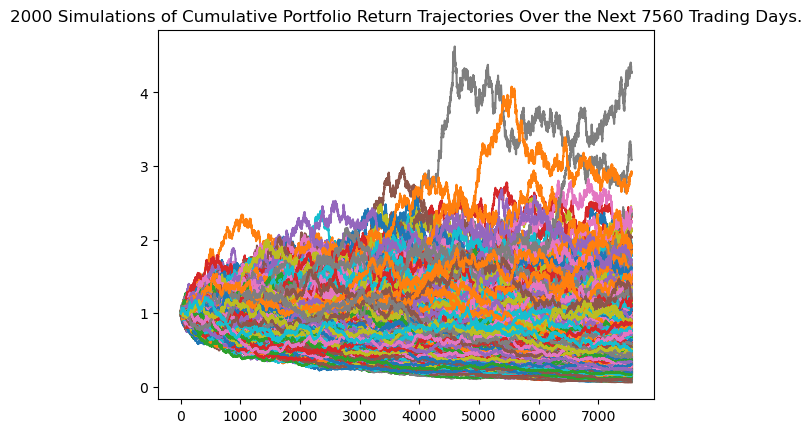

In [70]:
MC_sim_line_plot = MC_thirty_year.plot_simulation()

Visualizations lets us understand the range of outcome the user
will likely face when choosing to purchase our financial product. The goal will be to maximize long-term stability and growth, with low volatility. This has ben made possible by screening our stocks

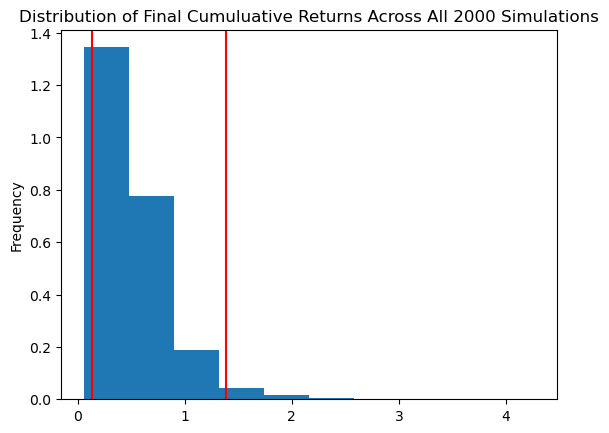

In [68]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram - 
MC_sim_dist_plot = MC_thirty_year.plot_distribution()

print("The histogram predictive plot has shown that 

## Analyzing the Portfolio Stocks, Individually.

In [76]:
print(" CALCULATION OF RISK UNDER ONE (1) STANDARD DEVIATION : ")
print("  ")


n = 1 
for ticker in tickers :  
    mean = daily_returns_df[ticker].mean()
    std = daily_returns_df[ticker].std() 
    daily_return_probability_plus = (mean + std) * 100
    daily_return_probability_minus = (mean - std) * 100
    print(f"{n}.({ticker}) :  A 95% probability exists that the daily value of {ticker} will likely be the mean ({mean}) plus or minus two standard deviations ({std})")
    print("-------")
    print(f"   that gives us a range of : {daily_return_probability_minus}%")
    print(f"   to : +{daily_return_probability_plus}%")
    nf_lower_bound_return = mean - (1.96 * std)
    nf_upper_bound_return = mean + (1.96 * std)
    nn_lower_bound_return = mean - (2.576 * std)
    nn_upper_bound_return = mean + (2.576 * std)
    print("-------")
    print(f" From the analysis of the {ticker} historical return data, with a 95% confidence interval, we can expect our daily return value to fall between {nf_lower_bound_return*100}% and +{nf_upper_bound_return*100}% ")    
    print("-------")
    rec_value = closing_prices_df[ticker].tail(1)
    lower_bound_price = rec_value.values * (1 - nf_lower_bound_return)
    print(f"            The lower bound of the expected price for the next day is ${lower_bound_price} We get that from the following equation: ")
    print (f"           {closing_prices_df[ticker].tail(1).values} * 1 - {nf_lower_bound_return} ") 
    upper_bound_price = rec_value.values * (1 + nf_upper_bound_return)
    print(f"            The upper bound of the expected price for the next day is ${upper_bound_price} We get that from the following equation: ")
    print(f"            {closing_prices_df[ticker].tail(1).values} * 1 + {nf_lower_bound_return} ") 
    print(f"            {ticker}")
    print("")
    print("")
    n = n + 1

 CALCULATION OF RISK UNDER one STANDARD DEVIATION : 
  
1.(UNM) :  A 95% probability exists that the daily value of UNM will likely be the mean (-0.0010188641178627753) plus or minus two standard deviations (0.02644281346367421)
-------
   that gives us a range of : -2.7461677581536987%
   to : +2.5423949345811434%
-------
 From the analysis of the UNM historical return data, with a 95% confidence interval, we can expect our daily return value to fall between -5.284677850666423% and +5.080905027093867% 
-------
            The lower bound of the expected price for the next day is $[17.37197185] We get that from the following equation: 
           [16.5] * 1 - -0.05284677850666423 
            The upper bound of the expected price for the next day is $[17.33834933] We get that from the following equation: 
            [16.5] * 1 + -0.05284677850666423 
            UNM


2.(FTI) :  A 95% probability exists that the daily value of FTI will likely be the mean (-0.0012103132069815241) plus 

In [79]:
print(" CALCULATION OF RISK UNDER THREE (3) STANDARD DEVIATIONS : ")
print("  ")

n = 1 
for ticker in tickers :  
    mean = daily_returns_df[ticker].mean()
    std = daily_returns_df[ticker].std() * 3
    daily_return_probability_plus = (mean + std) * 100
    daily_return_probability_minus = (mean - std) * 100
    print(f"{n}.({ticker}) :  For a 99.7% probability exists that the daily value of {ticker} will likely be the mean ({mean}) plus or minus two standard deviations ({std})")
    print(f"   that gives us a range of : {daily_return_probability_minus}%")
    print(f"   to : +{daily_return_probability_plus}%")
    print("---------------------")
    down_tail_percentage = (mean - ( std)) * 100
    print(f"The downside tail-percentage of {ticker} is : {down_tail_percentage}%")
    up_tail_percentage = (mean + ( std)) * 100
    print(f"The upside tail-percentage of {ticker} is : +{up_tail_percentage}%")
    print(f"   {ticker}")
    print("")
    print("")
    n = n + 1

 CALCULATION OF RISK UNDER THREE (3) STANDARD DEVIATIONS : 
  
1.(UNM) :  For a 99.7% probability exists that the daily value of UNM will likely be the mean (-0.0010188641178627753) plus or minus two standard deviations (0.07932844039102263)
   that gives us a range of : -8.03473045088854%
   to : +7.830957627315986%
---------------------
The downside tail-percentage of UNM is : -8.03473045088854%
The upside tail-percentage of UNM is : +7.830957627315986%
   UNM


2.(FTI) :  For a 99.7% probability exists that the daily value of FTI will likely be the mean (-0.0012103132069815241) plus or minus two standard deviations (0.0931162570832805)
   that gives us a range of : -9.432657029026203%
   to : +9.190594387629899%
---------------------
The downside tail-percentage of FTI is : -9.432657029026203%
The upside tail-percentage of FTI is : +9.190594387629899%
   FTI


3.(LMT) :  For a 99.7% probability exists that the daily value of LMT will likely be the mean (0.0006170295153512097) plus o

<AxesSubplot:ylabel='Frequency'>

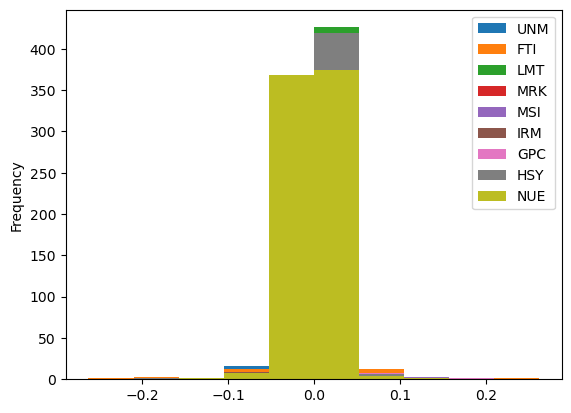

In [78]:
daily_returns_df.plot(kind='hist'
                     )

The (above) visualization will support our finding that the standard deviation of our portfolio is within an adequate range of values-- showing relatively low volatility. 

In [95]:
initial_investment = 10000
ci_lower_ten_cumulative_return = MC_thirty_summary_statistics[8] * initial_investment
ci_upper_ten_cumulative_return = MC_thirty_summary_statistics[9] * initial_investment

# Print the result of your calculations
print(f"There is a 95% chance that an initial investment of $ {initial_investment} in the portfolio"
    f" over the next 30 years will end within in the range of"
    f" ${ci_lower_ten_cumulative_return :2f} and ${ci_upper_ten_cumulative_return :2f}.")



There is a 95% chance that an initial investment of $ 10000 in the portfolio over the next 30 years will end within in the range of $1317.682014 and $13844.358664.


## Creating a Monte Carlo Simulation to Calculate Optimal Weight Distribution

In [94]:
from io import BytesIO

import numpy as np
import numba as nb
import pandas as pd
import holoviews as hv
import panel as pn
from pathlib import Path

from scipy.optimize import minimize


In [96]:

from script import random_allocation
random_allocation(prices_df)

ImportError: cannot import name 'random_allocation' from 'script' (/Users/najibabounasr/Desktop/Berkley_Bootcamp/Project 1/Project_1_Portfolio_Curator-/script.py)